In [9]:
def separar_rutas(ruta):
    """
    Función que a partir de la ruta donde están todos los vehículos unidos
    los divide en sublistas una para cada vehículo.
    """
    rutas = [list(g) for k, g in groupby(ruta, lambda x: x == 0) if not k]
    for i in rutas:
        i.insert(0, 0)
        i.append(0)
    return rutas

In [10]:
def coste_ruta(seq, A):
    """
    Función que a partir de una ruta de un vehículo y la matriz distancias
    calcula el coste de dicha ruta.
    """
    coste = 0
    for k in range(len(seq)-1):
        coste += A.iloc[seq[k],seq[k+1]]
    return coste

In [11]:
def crear_solucion(nodos_visitados,demandas):
    """
    """
    cont = 1
    d = 0
    solucion = []
    for i in nodos_visitados:
        cadena = "Ruta "+str(cont)+": "
        for j in i:
            if j == 0:
                cadena += str(j)
            else:
                cadena += " - " + str(j) + "(" + str(demandas[d]) + ")"
                d += 1
        cont += 1
        cadena = cadena[:-1] + " - 0"
        solucion.append(cadena)  
    return solucion

In [12]:
def dibujo_rutas_pdf(lista_rutas, lista_datos, fichero, titulo, colores = ["green","red","blue","orange","cyan", "grey"]):
    nveh = len(lista_rutas)
    dibu = list(zip(lista_datos["CoordX"], lista_datos["CoordY"]))

    with PdfPages(fichero) as pdf:
        fig, ax = plt.subplots()
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titulo)

        for x, y in dibu:
            ax.text(x, y, '●', fontsize=18, fontweight='bold', ha='center', va='center')
        
        for i, (x, y) in enumerate(dibu):
            ax.text(x, y, str(i), fontsize=8, fontweight='bold', ha='center', va='center', color='white')

        for i in range(nveh):
            rutas_veh = [dibu[idx] for idx in lista_rutas[i]]
            x, y = zip(*rutas_veh)
            ax.plot(x, y, color=colores[i % len(colores)])

        pdf.savefig()

In [13]:
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
from matplotlib.backends.backend_pdf import PdfPages
import random
import time

In [14]:
fichero = pd.read_csv("C101_25.txt", 
                    sep="\t", 
                    escapechar="\\", 
                    engine='python')
datos = {"Etiquetas": fichero["Clientes"], 
         "CoordX": fichero["X"], 
         "CoordY": fichero["Y"], 
         "Demanda": fichero["Demandas"],
         "A": fichero["A"],
         "B": fichero['B'],
         "Servicio": fichero['Servicio']}

In [69]:
def VRP(fichero):
    coordenadas=fichero[['X','Y']]
    distancias = pdist(coordenadas, metric="euclidean")
    distancias = squareform(distancias)
    distancias = pd.DataFrame(distancias) # Redondeamos la matriz

    distancias_devolver = distancias.copy() # Hacemos una copia de la matriz original

    distancias.replace(0, np.inf, inplace=True) # Ponemos los 0 a infinito para no seleccionarlos como mínimo
    distancias_copia = distancias.copy() # Creamos una copia para al repetir el bucle no perder la matriz original con los 0 en infinito

    ventanas=fichero[['A','B']]
    ventanas.iloc[0,0]=np.inf

    # Inicializar variables
    num_nodos = len(fichero) # Número de nodos
    capacidad_camion = 200 # Capacidad total del camión
    capacidad_restante = capacidad_camion # Asignamos la capacidad restante a la capacidad del camión

    lista_demanda = datos["Demanda"].to_list() # Creamos una lista con las demandas
    n_vehiculos = 3 # Número de vehículos
    total_lista = num_nodos + 2*(n_vehiculos - 1) # Calculamos el total de la lista

    nodo_actual = 0 # Ponemos el nodo inicial al nodo 1 (0)
    nodos_visitados = [0] # Creamos la ruta de nodos que va a seguir el camión
    lista_acabados = [0] # Lista de nodos que ya hemos dejado toda la demanda
    tiempo=0
    lista_demandas_actualizadas = []
    ventanas_copia=ventanas.copy()
    pasar_opt=[]

    while len(nodos_visitados) < total_lista:
        print(nodos_visitados)
        nodo_siguiente=ventanas.iloc[:,1].idxmin()
        
        if tiempo>ventanas.iloc[nodo_siguiente,1]:
            print(nodo_siguiente)
            print(tiempo)
            ventanas.iloc[nodo_siguiente,1]=np.inf


        else:
            tiempo_aux=distancias.iloc[nodo_siguiente,nodo_actual]
            tiempo+=tiempo_aux
            if tiempo<ventanas.iloc[nodo_siguiente,0]:
                tiempo=ventanas.iloc[nodo_siguiente,0]+tiempo_aux


            if lista_demanda[nodo_siguiente]<=capacidad_restante:
                capacidad_restante-=lista_demanda[nodo_siguiente]
                tiempo+=fichero.iloc[nodo_siguiente,6]


                if capacidad_restante==0:              
                    lista_acabados.append(nodo_siguiente)
                    nodos_visitados.append(nodo_siguiente)
                    nodo_actual=0
                    tiempo=0           
                    ventanas.iloc[nodo_actual,1]=np.inf
                    ventanas.iloc[nodo_siguiente,1]=np.inf
                    capacidad_restante=capacidad_camion
                    nodos_visitados.append(nodo_actual)

                    if nodo_siguiente!=0:
                        lista_demandas_actualizadas.append(lista_demanda[nodo_siguiente])
                    for i in lista_acabados:
                        ventanas.iloc[i] = np.inf


                elif tiempo>ventanas.iloc[0,1]:               
                    ventanas.iloc[nodo_actual,1]=np.inf
                    ventanas.iloc[nodo_siguiente,1]=np.inf
                    tiempo=0
                    nodo_actual=0
                    nodos_visitados.append(nodo_actual)             
                    capacidad_restante=capacidad_camion
                    if nodo_siguiente!=0:
                        lista_demandas_actualizadas.append(lista_demanda[nodo_siguiente])
                    ventanas = ventanas_copia.copy()
                    for i in lista_acabados:
                        ventanas.iloc[i] = np.inf


                else:
                    lista_acabados.append(nodo_siguiente)
                    nodos_visitados.append(nodo_siguiente)
                    pasar_opt.append((nodo_siguiente,lista_demanda[nodo_siguiente]))
                    if nodo_siguiente!=0:
                        lista_demandas_actualizadas.append(lista_demanda[nodo_siguiente])
                    ventanas.iloc[nodo_siguiente,1]=np.inf
                    nodo_actual=nodo_siguiente


            else:
                nodo_actual=0
                tiempo=0
                nodos_visitados.append(nodo_actual)
                capacidad_restante=capacidad_camion
                ventanas = ventanas_copia.copy()
                for i in lista_acabados:
                    ventanas.iloc[i] = np.inf
    nodos_visitados = separar_rutas(nodos_visitados)
    total=0
    for i in nodos_visitados:
        total+=coste_ruta(i, distancias_devolver)
    solucion = crear_solucion(nodos_visitados,lista_demandas_actualizadas)
    rutas = [list(g) for k, g in groupby(pasar_opt, lambda x: x == (0,0)) if not k]
    for i in rutas:
        i.insert(0, (0,0))
        i.append((0,0))     
    
    dibujo_rutas_pdf(nodos_visitados, datos, 'VRPTW.pdf', 'Tour del VRPTW')
    
    return nodos_visitados, distancias_devolver, total, solucion, rutas


[0]
[0, 5]
20
105.13274595042155
[0, 5]
13
105.13274595042155
[0, 5]
[0, 5, 24]
3
217.8043140479308
[0, 5, 24]
17
217.8043140479308
[0, 5, 24]
[0, 5, 24, 25]
7
309.8043140479308
[0, 5, 24, 25]
18
309.8043140479308
[0, 5, 24, 25]
[0, 5, 24, 25, 8]
19
420.41984217601913
[0, 5, 24, 25, 8]
10
420.41984217601913
[0, 5, 24, 25, 8]
[0, 5, 24, 25, 8, 15]
11
532.053149828803
[0, 5, 24, 25, 8, 15]
16
532.053149828803
[0, 5, 24, 25, 8, 15]
[0, 5, 24, 25, 8, 15, 9]
14
642.644410110777
[0, 5, 24, 25, 8, 15, 9]
[0, 5, 24, 25, 8, 15, 9, 6]
12
734.8804780882768
[0, 5, 24, 25, 8, 15, 9, 6]
[0, 5, 24, 25, 8, 15, 9, 6, 23]
4
843.3195670028626
[0, 5, 24, 25, 8, 15, 9, 6, 23]
[0, 5, 24, 25, 8, 15, 9, 6, 23, 2]
22
955.9911351003719
[0, 5, 24, 25, 8, 15, 9, 6, 23, 2]
[0, 5, 24, 25, 8, 15, 9, 6, 23, 2, 0]
[0, 5, 24, 25, 8, 15, 9, 6, 23, 2, 0, 20]
13
100.0
[0, 5, 24, 25, 8, 15, 9, 6, 23, 2, 0, 20]
[0, 5, 24, 25, 8, 15, 9, 6, 23, 2, 0, 20, 3]
17
210.0
[0, 5, 24, 25, 8, 15, 9, 6, 23, 2, 0, 20, 3]
[0, 5, 24, 25, 

([[0, 5, 24, 25, 8, 15, 9, 6, 23, 2, 0],
  [0, 20, 3, 7, 19, 11, 14, 12, 4, 22, 0]],
            0          1          2          3          4          5   \
 0    0.000000  18.681542  20.615528  16.124515  18.110770  15.132746   
 1   18.681542   0.000000   2.000000   3.605551   3.000000   4.242641   
 2   20.615528   2.000000   0.000000   5.000000   3.605551   5.830952   
 3   16.124515   3.605551   5.000000   0.000000   2.000000   1.000000   
 4   18.110770   3.000000   3.605551   2.000000   0.000000   3.000000   
 5   15.132746   4.242641   5.830952   1.000000   3.000000   0.000000   
 6   19.000000   5.099020   5.099020   3.605551   2.236068   4.472136   
 7   16.000000   5.385165   6.403124   2.000000   2.828427   2.236068   
 8   18.110770   7.000000   7.280110   4.472136   4.000000   5.000000   
 9   20.099751   7.280110   7.000000   5.656854   4.472136   6.403124   
 10  16.763055  10.198039  10.770330   7.000000   7.280110   7.071068   
 11  19.646883  10.049876  10.049876   

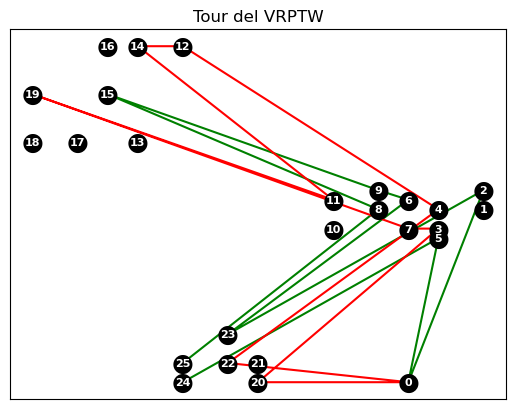

In [70]:
VRP(fichero)

In [58]:
ventanas=fichero[['A','B']]
ventanas.iloc[0,0]=np.inf
ventanas

,A,B
0,inf,1236
1,912.0,967
2,825.0,870
3,65.0,146
4,727.0,782
5,15.0,67
6,621.0,702
7,170.0,225
8,255.0,324
9,534.0,605


In [60]:
coordenadas=fichero[['X','Y']]
distancias = pdist(coordenadas, metric="euclidean")
distancias = squareform(distancias)
distancias = pd.DataFrame(distancias)
distancias

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.000000,18.681542,20.615528,16.124515,18.110770,15.132746,19.000000,16.000000,18.110770,20.099751,...,40.311289,33.301652,35.355339,39.051248,10.000000,10.198039,12.165525,13.000000,15.000000,15.132746
1,18.681542,0.000000,2.000000,3.605551,3.000000,4.242641,5.099020,5.385165,7.000000,7.280110,...,30.232433,27.892651,30.805844,32.310989,23.430749,21.931712,23.345235,21.400935,26.907248,25.612497
2,20.615528,2.000000,0.000000,5.000000,3.605551,5.830952,5.099020,6.403124,7.280110,7.000000,...,29.154759,27.459060,30.413813,31.622777,25.000000,23.430749,24.758837,22.671568,28.284271,26.907248
3,16.124515,3.605551,5.000000,0.000000,2.000000,1.000000,3.605551,2.000000,4.472136,5.656854,...,29.068884,25.632011,28.460499,30.413813,20.000000,18.439089,19.798990,17.804494,23.345235,22.022716
4,18.110770,3.000000,3.605551,2.000000,0.000000,3.000000,2.236068,2.828427,4.000000,4.472136,...,27.802878,25.000000,27.892651,29.546573,21.633308,20.000000,21.260292,19.104973,24.758837,23.345235
5,15.132746,4.242641,5.830952,1.000000,3.000000,0.000000,4.472136,2.236068,5.000000,6.403124,...,29.732137,26.000000,28.792360,30.886890,19.209373,17.691806,19.104973,17.204651,22.671568,21.400935
6,19.000000,5.099020,5.099020,3.605551,2.236068,4.472136,0.000000,3.000000,2.236068,2.236068,...,25.612497,22.803509,25.709920,27.313001,21.470911,19.723083,20.808652,18.439089,24.207437,22.671568
7,16.000000,5.385165,6.403124,2.000000,2.828427,2.236068,3.000000,0.000000,2.828427,4.472136,...,27.586228,23.769729,26.570661,28.653098,18.867962,17.204651,18.439089,16.278821,21.931712,20.518285
8,18.110770,7.000000,7.280110,4.472136,4.000000,5.000000,2.236068,2.828427,0.000000,2.000000,...,24.758837,21.189620,24.041631,25.942244,19.697716,17.888544,18.867962,16.401219,22.203603,20.615528
9,20.099751,7.280110,7.000000,5.656854,4.472136,6.403124,2.236068,4.472136,2.000000,0.000000,...,23.430749,20.615528,23.537205,25.079872,21.540659,19.697716,20.591260,18.027756,23.853721,22.203603
